In [0]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving food_delivery_reviews.csv to food_delivery_reviews.csv
User uploaded file "food_delivery_reviews.csv" with length 8332976 bytes


In [0]:
!nvidia-smi

Wed May 20 19:13:37 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
!pip install -qq transformers

     |████████████████████████████████| 645kB 8.9MB/s 
     |████████████████████████████████| 890kB 63.8MB/s 
     |████████████████████████████████| 3.8MB 46.3MB/s 
     |████████████████████████████████| 1.1MB 59.6MB/s 


In [0]:
!pip install -q -U watermark

In [0]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

CPython 3.6.9
IPython 5.5.0

numpy 1.18.4
pandas 1.0.3
torch 1.5.0+cu101
transformers 2.9.1


In [0]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [0]:
df = pd.read_csv("food_delivery_reviews.csv")
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,gp:AOqpTOF9hsURyAMTxPPIwn2-wiZ9w-1dKX0t39NWxUj...,Mickey Louse,https://lh3.googleusercontent.com/a-/AOh14GhQv...,Impossible to create a new account. It keeps r...,1,273,12.5.3,2020-04-25 23:34:34,NaN,NaN,most_relevant,com.dd.doordash
1,gp:AOqpTOFBDKMMguyXSUQkmgf3lqfRCXa1je3hAmcdGYV...,Drew Love,https://lh3.googleusercontent.com/-iqdRZkMh1Yc...,"Originally when I downloaded the app, I was pl...",1,294,12.6.2,2020-05-06 22:27:25,NaN,NaN,most_relevant,com.dd.doordash
2,gp:AOqpTOFLb9-EpmZe6zD-6jZt5N8X2IbJb_SvOWtSg6a...,Katherine Smith,https://lh3.googleusercontent.com/a-/AOh14Ggj7...,I wish I could give this app a zero. Who ever ...,1,122,12.5.3,2020-05-06 18:35:51,NaN,NaN,most_relevant,com.dd.doordash
3,gp:AOqpTOEaQahe4VCzNWiaKoGpCREs-BoKCJBVXyQ0oF1...,C4PTIVE,https://lh3.googleusercontent.com/a-/AOh14GhfL...,All of my emails were used to make an account ...,1,64,12.5.3,2020-05-07 14:54:00,NaN,NaN,most_relevant,com.dd.doordash
4,gp:AOqpTOHS1mjHqih9jwNbD7fk-OpUGkiziSPsL3ZR9cW...,Adrian Combs,https://lh3.googleusercontent.com/-yI2Ce3_kHFI...,Not so much app issues as company issues. Firs...,1,85,12.6.4,2020-05-17 15:58:14,NaN,NaN,most_relevant,com.dd.doordash


In [0]:
df.shape

(17832, 12)

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17832 entries, 0 to 17831
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              17832 non-null  object
 1   userName              17832 non-null  object
 2   userImage             17832 non-null  object
 3   content               17832 non-null  object
 4   score                 17832 non-null  int64 
 5   thumbsUpCount         17832 non-null  int64 
 6   reviewCreatedVersion  16204 non-null  object
 7   at                    17832 non-null  object
 8   replyContent          2741 non-null   object
 9   repliedAt             2741 non-null   object
 10  sortOrder             17832 non-null  object
 11  appId                 17832 non-null  object
dtypes: int64(2), object(10)
memory usage: 1.6+ MB


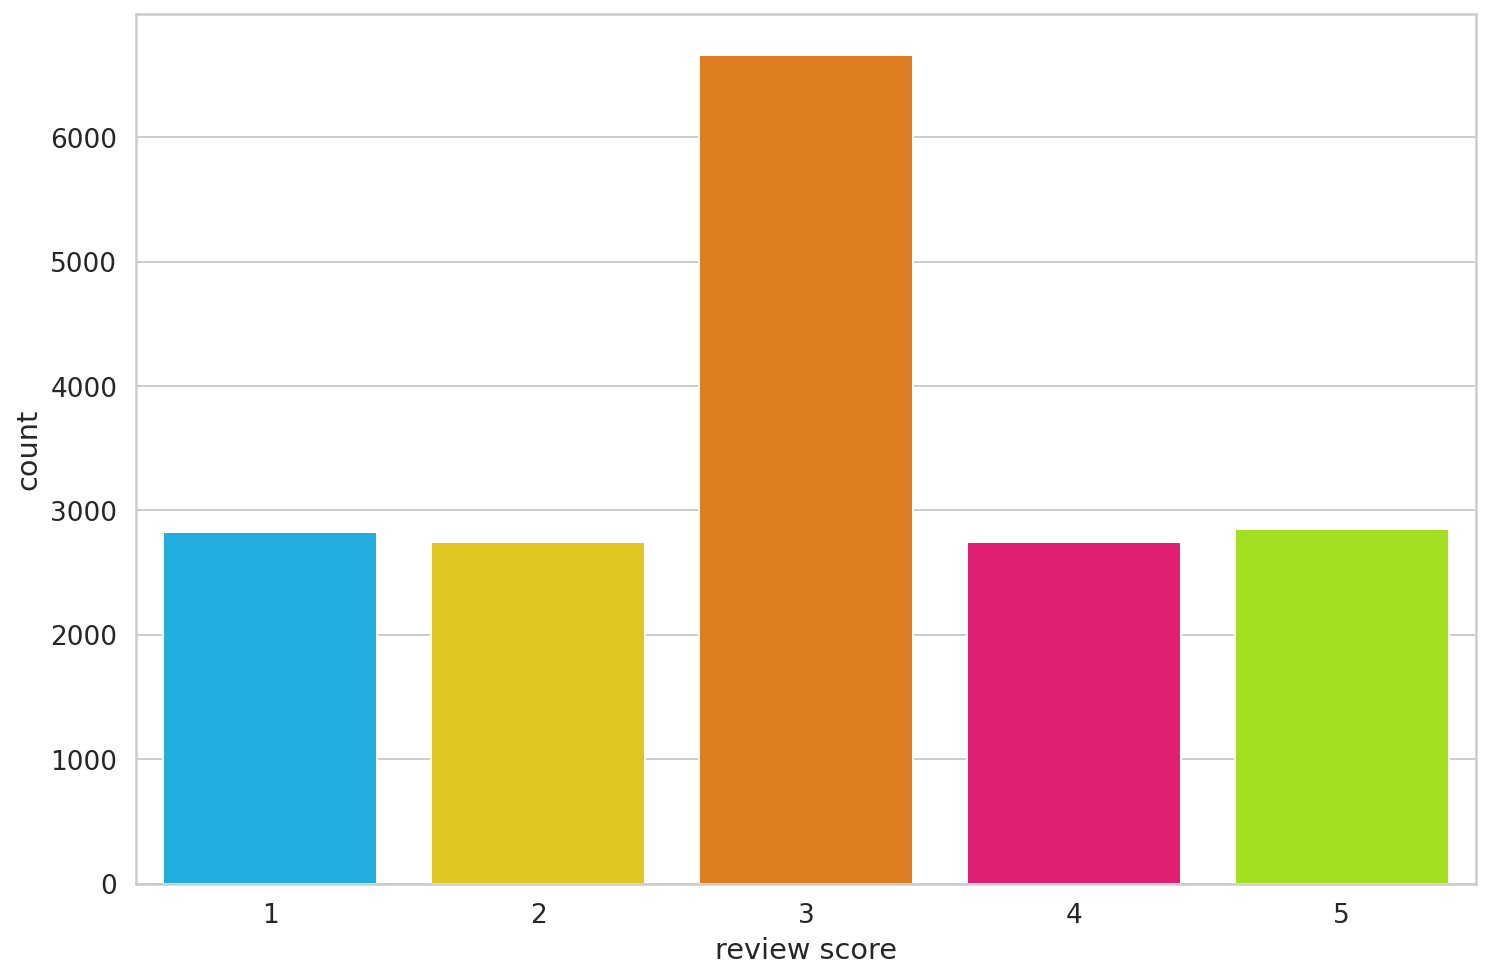

In [0]:
sns.countplot(df.score)
plt.xlabel('review score');

In [0]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else: 
    return 2

df['sentiment'] = df.score.apply(to_sentiment)

In [0]:
class_names = ['negative', 'neutral', 'positive']

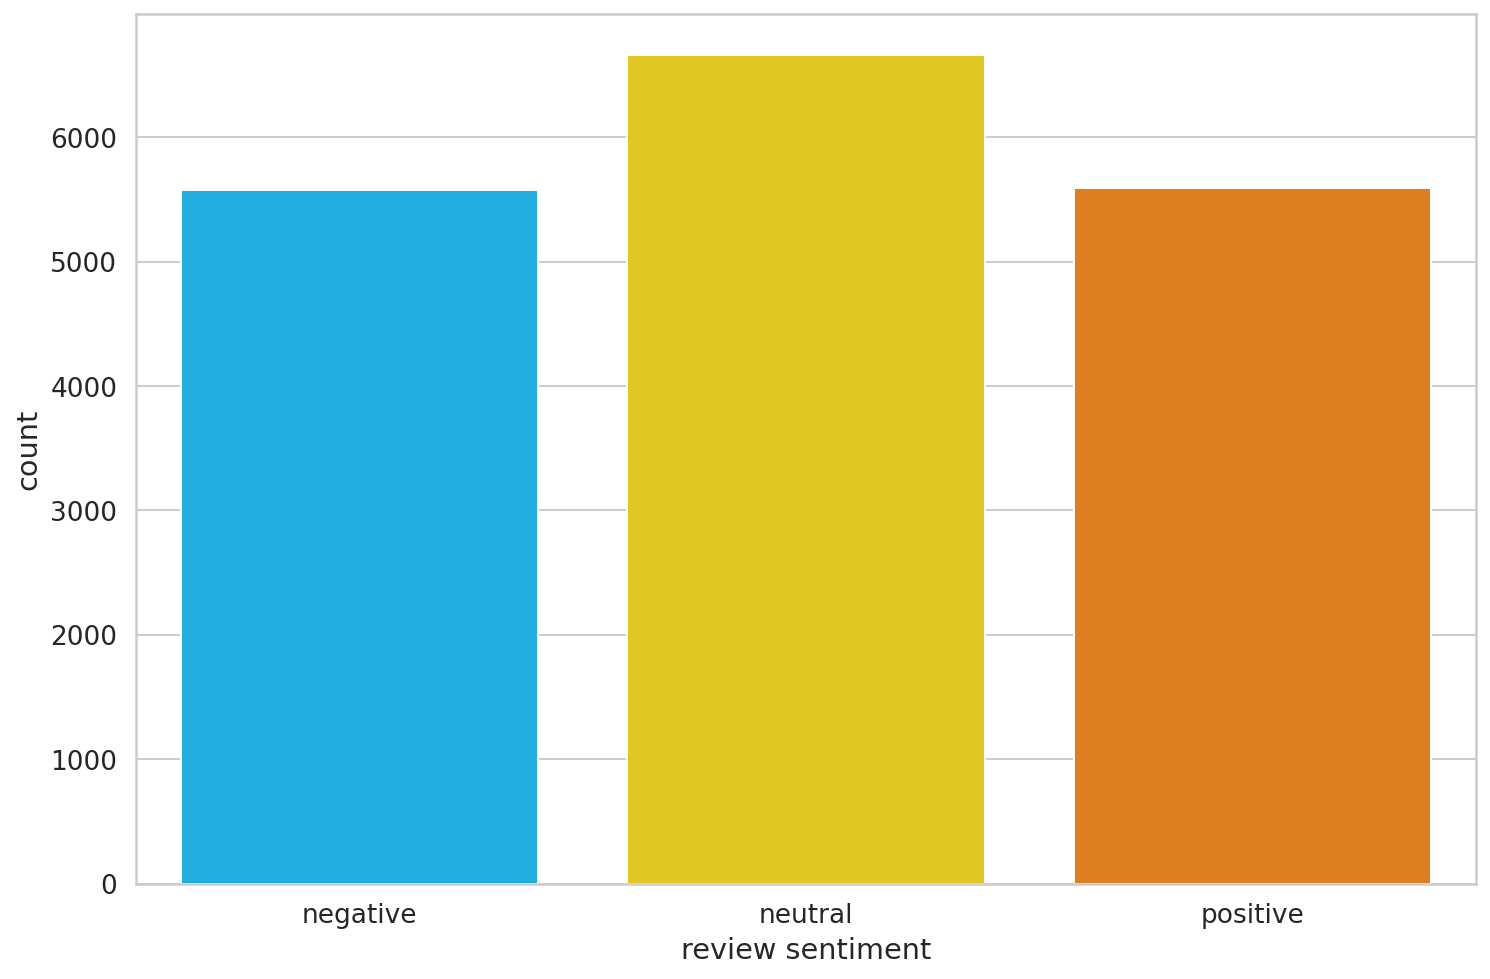

In [0]:
ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

In [0]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [0]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [0]:
sample_txt=df.iloc[0,3]
sample_txt

"Impossible to create a new account. It keeps resetting back to the beginning after going through google verification and putting in some crucial info. then when I went to try and make an account without Google verification, it said that my email was already used. Yet I can't sign in to save my life despite passing verification, twice. really frustrating as I already walked down to the restaurant to find out I had to order online. Now I can't even do that. Hungry and upset, to say the least."

In [0]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: Impossible to create a new account. It keeps resetting back to the beginning after going through google verification and putting in some crucial info. then when I went to try and make an account without Google verification, it said that my email was already used. Yet I can't sign in to save my life despite passing verification, twice. really frustrating as I already walked down to the restaurant to find out I had to order online. Now I can't even do that. Hungry and upset, to say the least.
   Tokens: ['Impossible', 'to', 'create', 'a', 'new', 'account', '.', 'It', 'keeps', 're', '##sett', '##ing', 'back', 'to', 'the', 'beginning', 'after', 'going', 'through', 'go', '##og', '##le', 've', '##rification', 'and', 'putting', 'in', 'some', 'crucial', 'info', '.', 'then', 'when', 'I', 'went', 'to', 'try', 'and', 'make', 'an', 'account', 'without', 'Google', 've', '##rification', ',', 'it', 'said', 'that', 'my', 'email', 'was', 'already', 'used', '.', 'Yet', 'I', 'can', "'", 't', '

In [0]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

In [0]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

In [0]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

In [0]:


encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()



dict_keys(['input_ids', 'attention_mask'])

In [0]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([  101, 26138,  1106,  2561,   170,  1207,  3300,   119,  1135,  7634,
         1231, 26448,  1158,  1171,  1106,  1103,  2150,  1170,  1280,  1194,
         1301,  8032,  1513,  1396, 12231,  1105,  4518,  1107,  1199, 10268,
        23992,   102])

In [0]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1]])

In [0]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'Impossible',
 'to',
 'create',
 'a',
 'new',
 'account',
 '.',
 'It',
 'keeps',
 're',
 '##sett',
 '##ing',
 'back',
 'to',
 'the',
 'beginning',
 'after',
 'going',
 'through',
 'go',
 '##og',
 '##le',
 've',
 '##rification',
 'and',
 'putting',
 'in',
 'some',
 'crucial',
 'info',
 '[SEP]']

In [0]:
token_lens = []

for txt in df.content:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

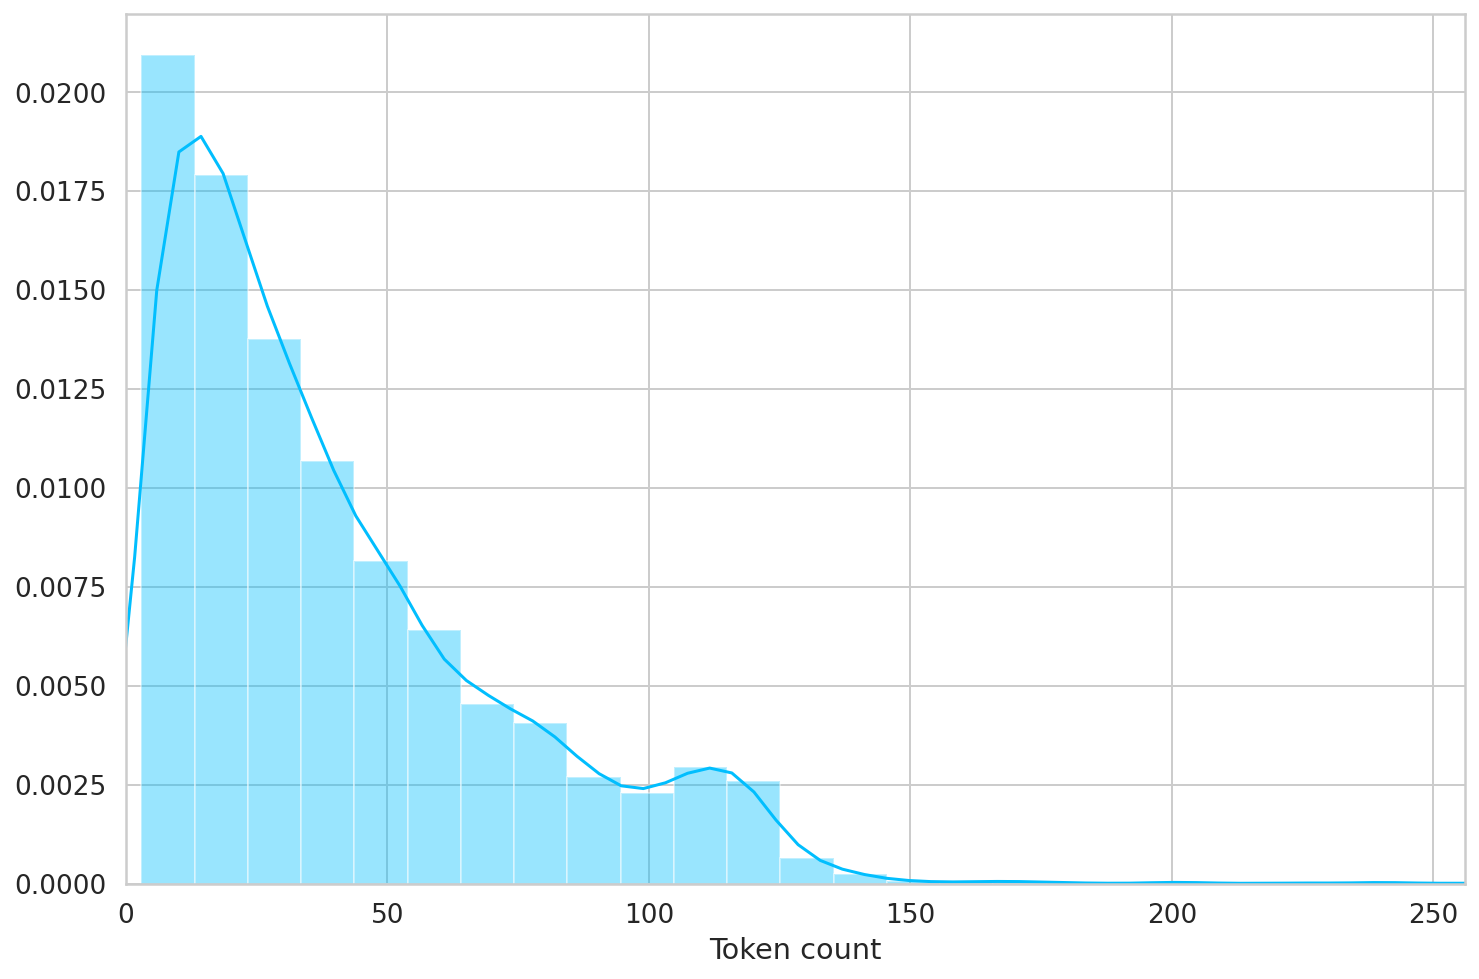

In [0]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [0]:
MAX_LEN = 180

In [0]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [0]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [0]:
df_train.shape, df_val.shape, df_test.shape

((16048, 13), (892, 13), (892, 13))

In [0]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.content.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [0]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [0]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [0]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 180])
torch.Size([16, 180])
torch.Size([16])


In [0]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [0]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
)

In [0]:
last_hidden_state.shape

torch.Size([1, 32, 768])

In [0]:
bert_model.config.hidden_size

768

In [0]:
pooled_output.shape

torch.Size([1, 768])

In [0]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [0]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [0]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 180])
torch.Size([16, 180])


In [0]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.4404, 0.1778, 0.3818],
        [0.5214, 0.1348, 0.3439],
        [0.2742, 0.1332, 0.5926],
        [0.5810, 0.1164, 0.3027],
        [0.5687, 0.1691, 0.2622],
        [0.3588, 0.1568, 0.4844],
        [0.4364, 0.1323, 0.4313],
        [0.3085, 0.2922, 0.3993],
        [0.3380, 0.1529, 0.5091],
        [0.2596, 0.2179, 0.5225],
        [0.4206, 0.1644, 0.4150],
        [0.3931, 0.2305, 0.3764],
        [0.5391, 0.0919, 0.3690],
        [0.4862, 0.1560, 0.3578],
        [0.4003, 0.1772, 0.4225],
        [0.3544, 0.1966, 0.4490]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [0]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [0]:


def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)



In [0]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [0]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------


/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


Train loss 0.7344057043551924 accuracy 0.6684322033898304
Val   loss 0.5990031364240817 accuracy 0.7533632286995515

Epoch 2/10
----------
Train loss 0.43998233379716295 accuracy 0.830259222333001
Val   loss 0.6470423586932676 accuracy 0.7780269058295964

Epoch 3/10
----------
Train loss 0.25579859564454105 accuracy 0.9150672981056829
Val   loss 0.8626108377107552 accuracy 0.797085201793722

Epoch 4/10
----------
Train loss 0.1742024090947028 accuracy 0.9521435692921235
Val   loss 1.006214767029243 accuracy 0.8082959641255605

Epoch 5/10
----------
Train loss 0.13203369237014564 accuracy 0.9677218344965104
Val   loss 1.2005982708984189 accuracy 0.8105381165919282

Epoch 6/10
----------
Train loss 0.09939480666535445 accuracy 0.9758225324027916
Val   loss 1.2476234609660293 accuracy 0.8116591928251121

Epoch 7/10
----------
Train loss 0.06812314725929457 accuracy 0.983611665004985
Val   loss 1.2830378679292542 accuracy 0.8172645739910314

Epoch 8/10
----------
Train loss 0.0581248607987

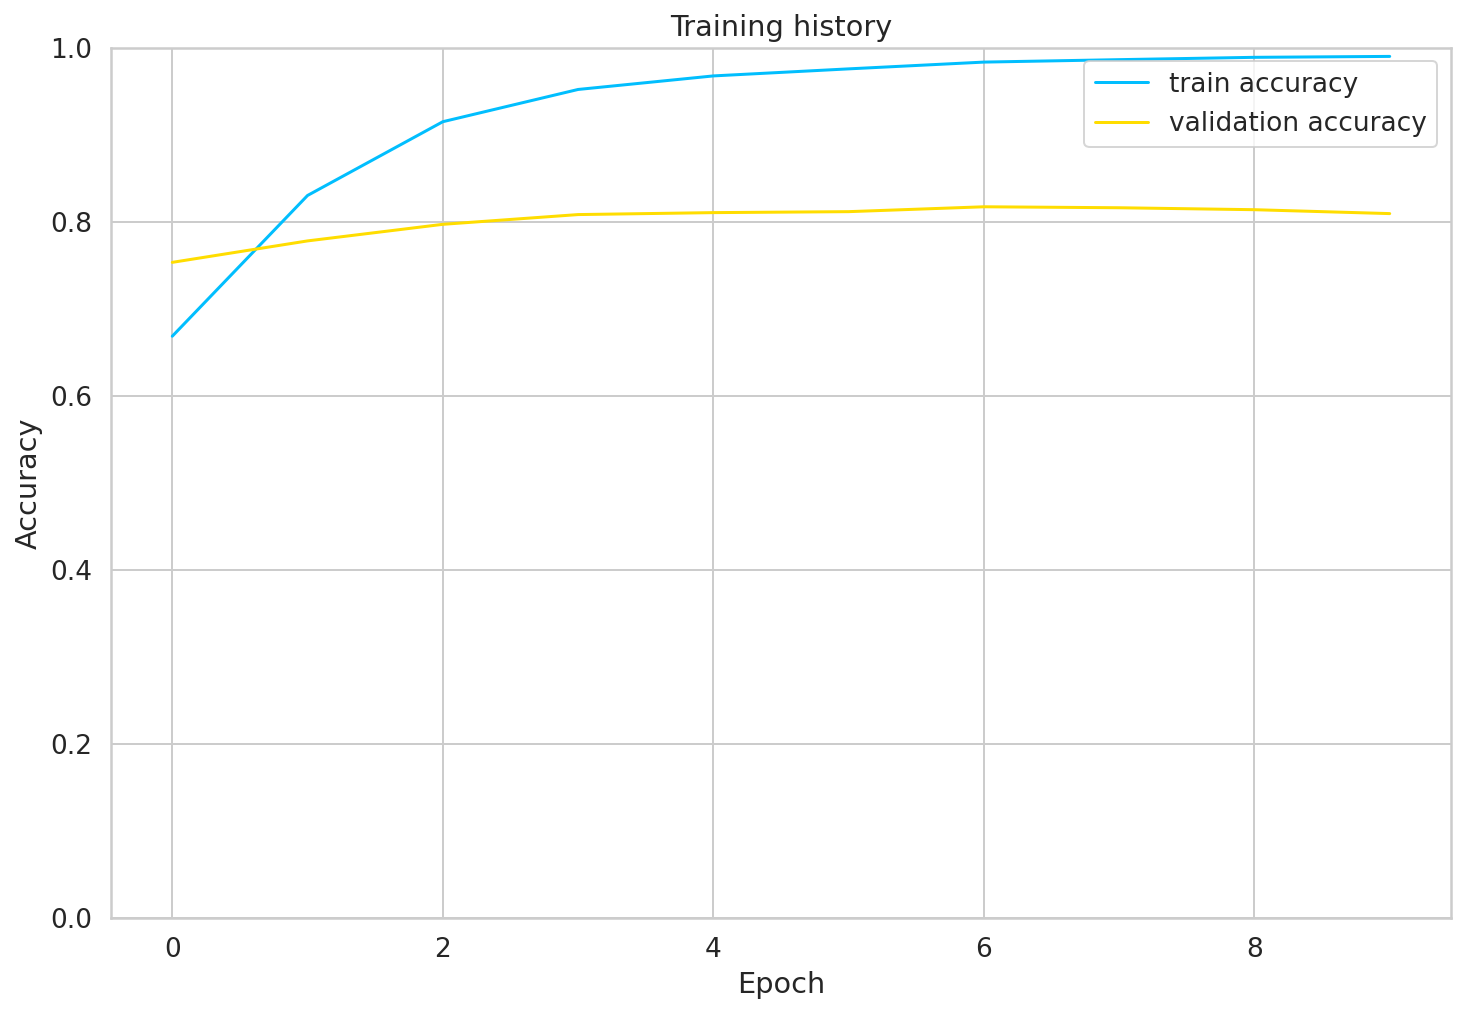

In [0]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [0]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.8486547085201793

In [0]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [0]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [0]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.86      0.84      0.85       274
     neutral       0.81      0.85      0.83       355
    positive       0.89      0.86      0.87       263

    accuracy                           0.85       892
   macro avg       0.85      0.85      0.85       892
weighted avg       0.85      0.85      0.85       892



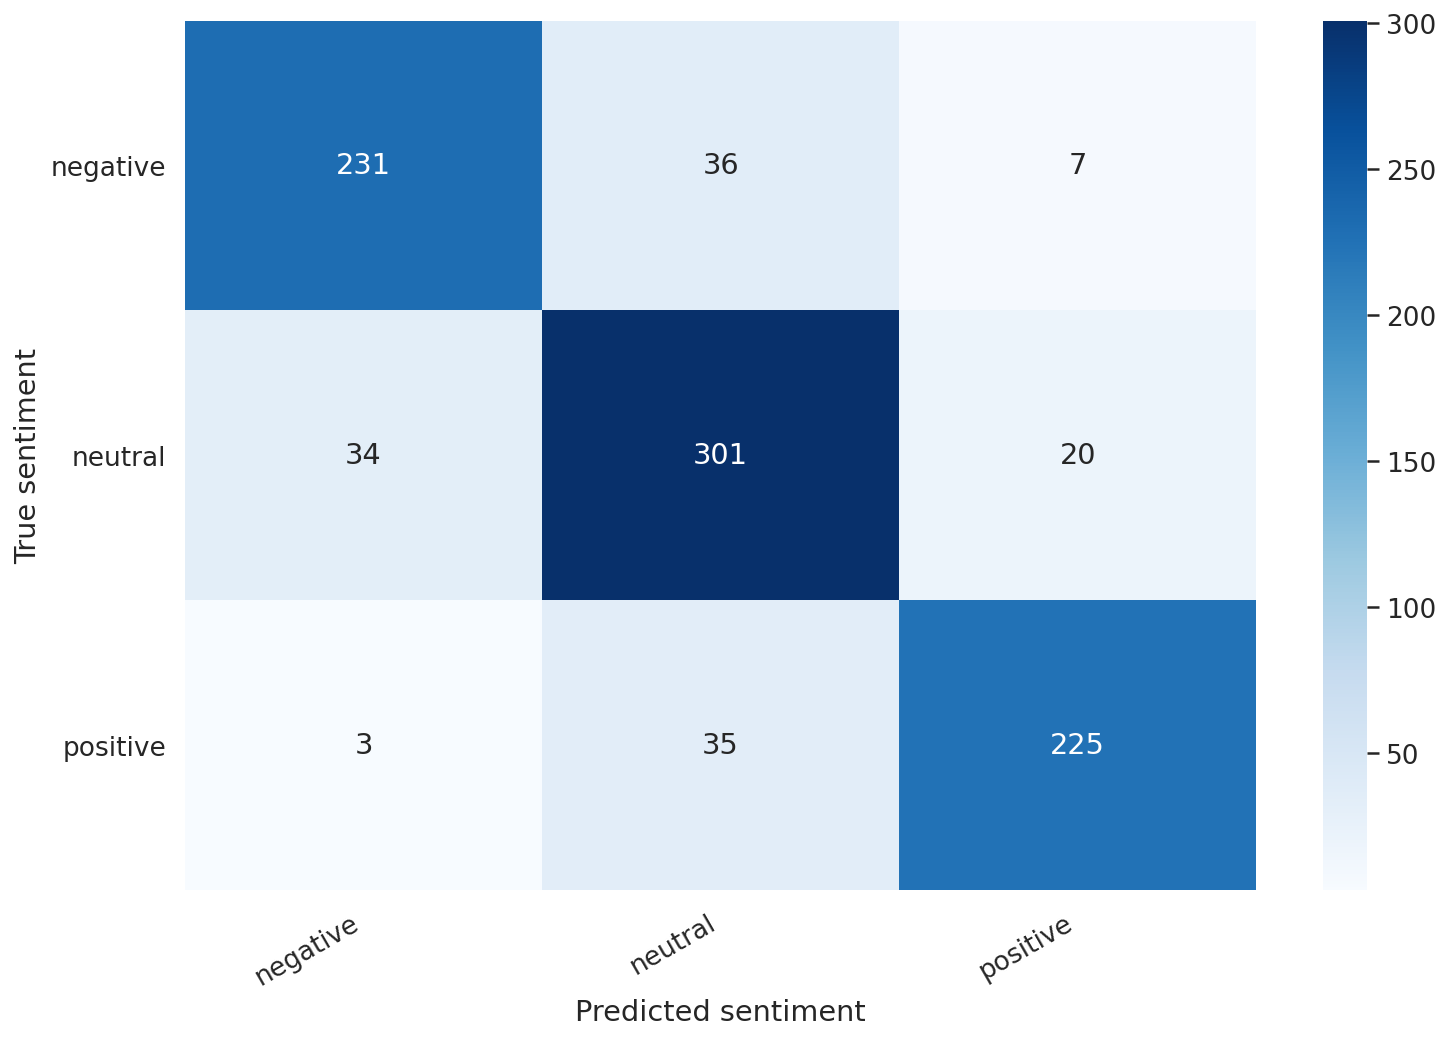

In [0]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [0]:
idx = 2

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [0]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

I.

True sentiment: neutral


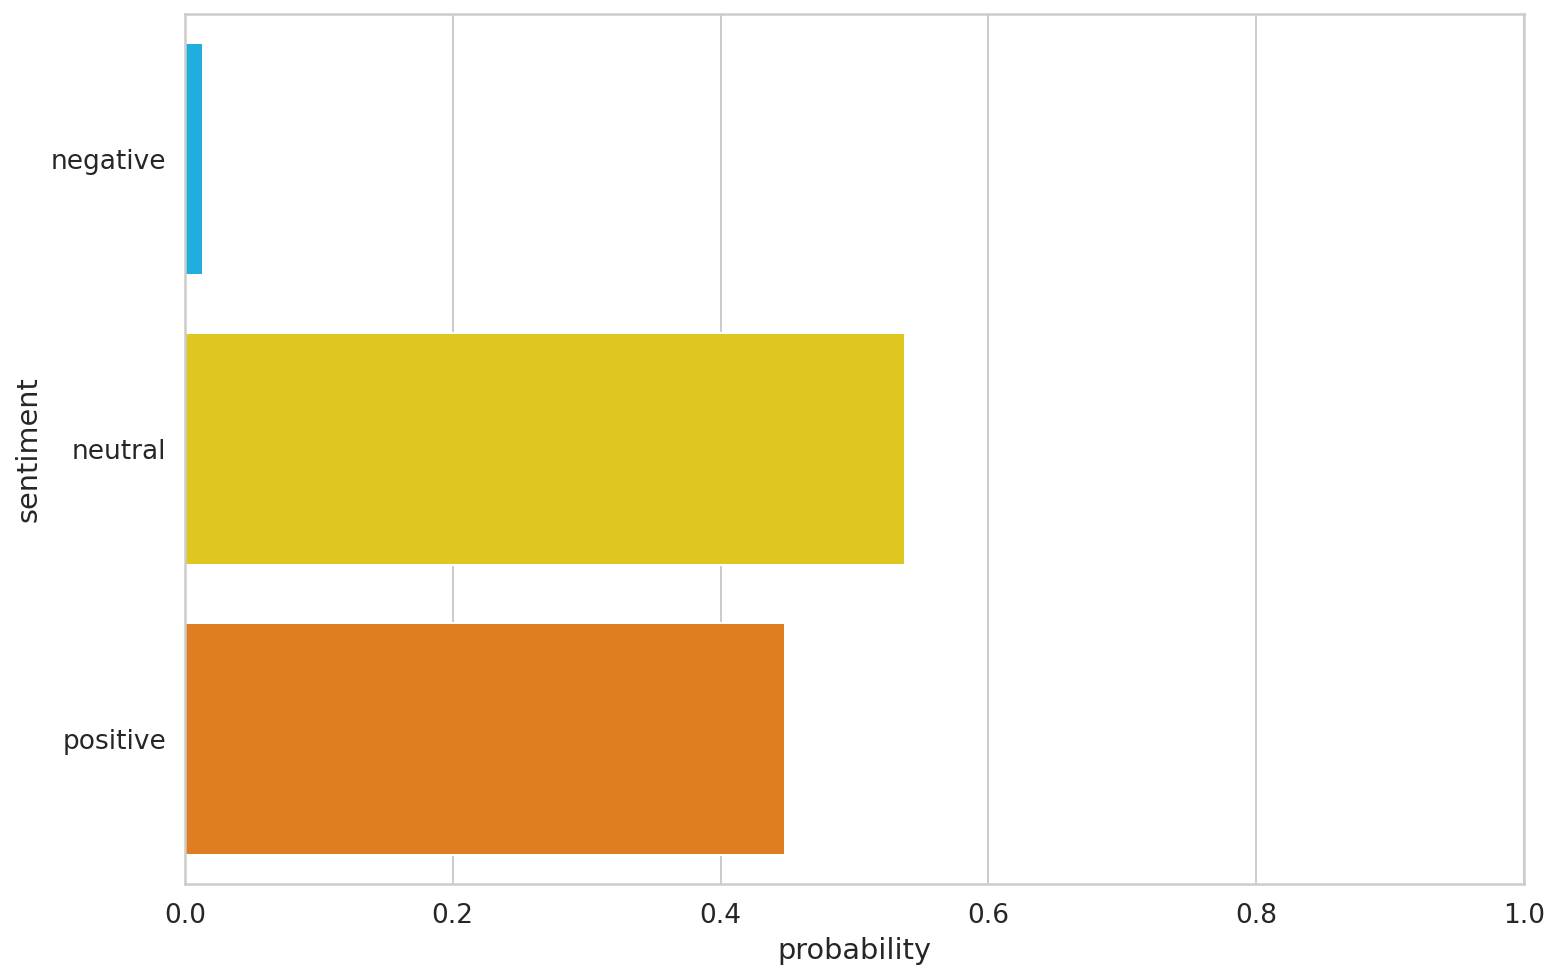

In [0]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

In [0]:
!gdown --id /content/best_model_state.bin

model = SentimentClassifier(len(class_names))
model.load_state_dict(torch.load('best_model_state.bin'))
model = model.to(device)

Permission denied: https://drive.google.com/uc?id=/content/best_model_state.bin
Maybe you need to change permission over 'Anyone with the link'?


NameError: ignored

In [0]:
from google.colab import drive
drive.mount('/content/drive')